In [1]:
import pandas as pd
import sklearn.ensemble
import sklearn.linear_model
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Data exploration

In [2]:
data=pd.read_csv("energydata_complete.csv")
data['date']=data['date'].apply(lambda dt: datetime.strptime(dt,"%Y-%m-%d %H:%M:%S"))

In [3]:
data['timeofday']=pd.Series([i.hour*60+i.minute for i in data['date']])
data['weekday']=pd.Series([i.weekday() for i in data['date']])
data

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,timeofday,weekday
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,6.600000,733.500000,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433,1020,0
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,6.483333,733.600000,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195,1030,0
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,6.366667,733.700000,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668,1040,0
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,6.250000,733.800000,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389,1050,0
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,6.133333,733.900000,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097,1060,0
5,2016-01-11 17:50:00,50,40,19.890000,46.026667,19.200000,44.500000,19.790000,44.933333,18.890000,...,6.016667,734.000000,92.000000,5.333333,43.833333,4.800000,44.919484,44.919484,1070,0
6,2016-01-11 18:00:00,60,50,19.890000,45.766667,19.200000,44.500000,19.790000,44.900000,18.890000,...,5.900000,734.100000,92.000000,5.000000,40.000000,4.700000,47.233763,47.233763,1080,0
7,2016-01-11 18:10:00,60,50,19.856667,45.560000,19.200000,44.500000,19.730000,44.900000,18.890000,...,5.916667,734.166667,91.833333,5.166667,40.000000,4.683333,33.039890,33.039890,1090,0
8,2016-01-11 18:20:00,60,40,19.790000,45.597500,19.200000,44.433333,19.730000,44.790000,18.890000,...,5.933333,734.233333,91.666667,5.333333,40.000000,4.666667,31.455702,31.455702,1100,0
9,2016-01-11 18:30:00,70,40,19.856667,46.090000,19.230000,44.400000,19.790000,44.863333,18.890000,...,5.950000,734.300000,91.500000,5.500000,40.000000,4.650000,3.089314,3.089314,1110,0


In [4]:
data.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,timeofday,weekday
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,...,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033,715.118824,2.977249
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,...,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634,415.667014,1.985617
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,0.000000,0.000000
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,...,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889,360.000000,1.000000
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653,720.000000,3.000000
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,...,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769,1070.000000,5.000000
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530,1430.000000,6.000000


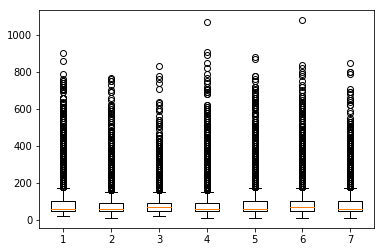

In [101]:
dayofweekdata=[]
for h in range(7):
    dayofweekdata.append(data.loc[data.loc[:,'weekday']==h].loc[:,'Appliances'].reset_index(drop=True))
plt.figure()
plt.boxplot(dayofweekdata)
plt.show()

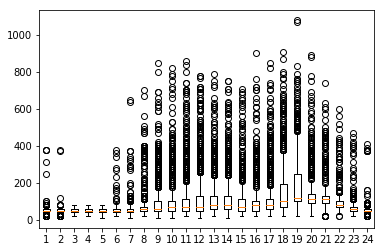

In [102]:
hourdata=[]
for h in range(24):
    hourdata.append(data.loc[(data.loc[:,'timeofday']>=60*h) & (data.loc[:,'timeofday']<60*(h+1))].loc[:,'Appliances'].reset_index(drop=True))
plt.figure()
plt.boxplot(hourdata)
plt.show()

# Random Forest

In [13]:
data_shuffle=data.sample(frac=1,random_state=19891014).reset_index(drop=True)

In [14]:
feature=list(data.columns)
feature.remove('rv1')
feature.remove('rv2')
feature.remove('date')
feature.remove('Appliances')
feature

['lights',
 'T1',
 'RH_1',
 'T2',
 'RH_2',
 'T3',
 'RH_3',
 'T4',
 'RH_4',
 'T5',
 'RH_5',
 'T6',
 'RH_6',
 'T7',
 'RH_7',
 'T8',
 'RH_8',
 'T9',
 'RH_9',
 'T_out',
 'Press_mm_hg',
 'RH_out',
 'Windspeed',
 'Visibility',
 'Tdewpoint',
 'timeofday',
 'weekday']

In [88]:
xtrain=np.array(data_shuffle.loc[:13800,feature]).copy(order='C')
ytrain=np.array(data_shuffle.loc[:13800,'Appliances']).copy(order='C')
xtest=np.array(data_shuffle.loc[13801:,feature]).copy(order='C')
ytest=np.array(data_shuffle.loc[13801:,'Appliances']).copy(order='C')

In [89]:
lm=sklearn.linear_model.Ridge()
lm.fit(xtrain,ytrain)
lm.score(xtest,ytest)

0.16667708657350888

In [90]:
yhat=lm.predict(xtest)
np.mean(np.power(yhat-ytest,2))

8877.9534608502963

# Random forest: The effect of shrinkage

In [104]:
N_ran=[i*100 for i in range(1,31)]
sk=[0.1,0.5,1]
testscore=[[0 for i in range(len(N_ran))]for j in range(len(sk))]
testmse=[[0 for i in range(len(N_ran))] for j in range(len(sk))]
trainscore=[[0 for i in range(len(N_ran))]for j in range(len(sk))]
trainmse=[[0 for i in range(len(N_ran))] for j in range(len(sk))]
for s in range(len(sk)):
    gb=sklearn.ensemble.GradientBoostingRegressor(learning_rate=sk[s],max_features=5,max_leaf_nodes=15,warm_start=True)
    for N in range(len(N_ran)):
        gb.set_params(n_estimators=N_ran[N])
        gb.fit(xtrain,ytrain)
        testscore[s][N]=gb.score(xtest,ytest)
        testmse[s][N]=gb.loss_(ytest,gb.predict(xtest))
        trainscore[s][N]=gb.score(xtrain,ytrain)
        trainmse[s][N]=gb.loss_(ytrain,gb.predict(xtrain))

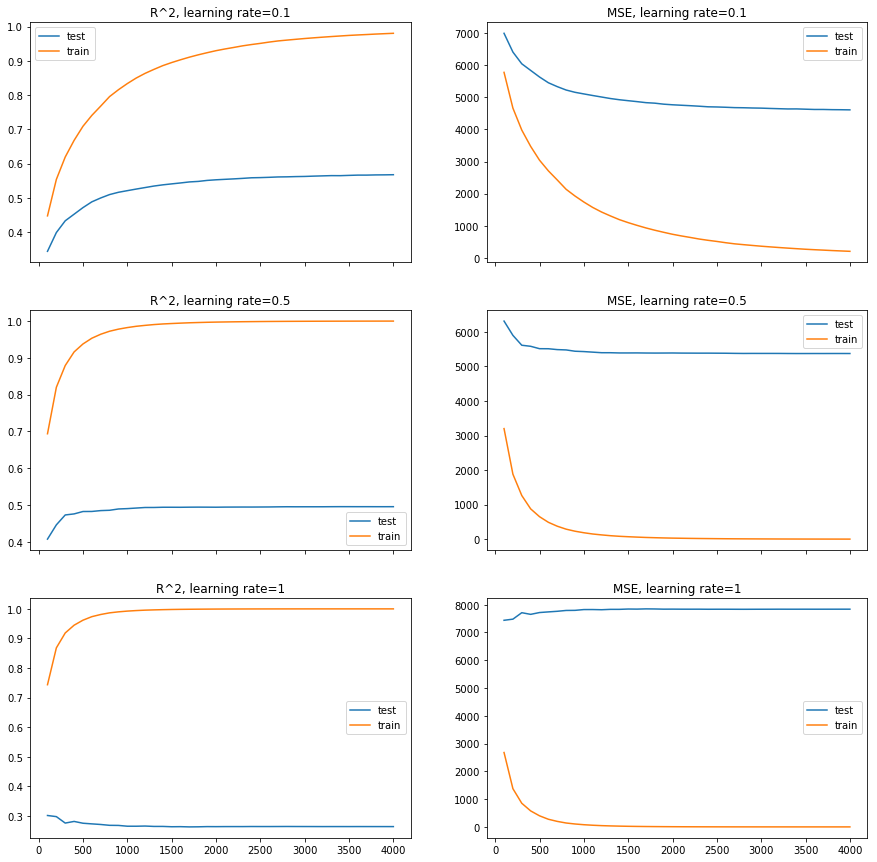

In [105]:
plt.figure()
f,plots=plt.subplots(3,2,sharex=True,figsize=(15,15))
for s in range(len(sk)):
    p1,=plots[s,0].plot(N_ran,testscore[s])
    p2,=plots[s,0].plot(N_ran,trainscore[s])
    plots[s,0].legend([p1,p2],["test","train"])
    plots[s,0].set_title("R^2, learning rate={}".format(sk[s]))
    p1,=plots[s,1].plot(N_ran,testmse[s])
    p2,=plots[s,1].plot(N_ran,trainmse[s])
    plots[s,1].legend([p1,p2],["test","train"])
    plots[s,1].set_title("MSE, learning rate={}".format(sk[s]))
plt.show()

# Random forest: feature number doesn't matter

In [106]:
N_ran=[i*100 for i in range(1,51)]
feature_ran=[5,10,15]
testscore=[[0 for i in range(len(N_ran))]for j in range(len(feature_ran))]
testmse=[[0 for i in range(len(N_ran))] for j in range(len(feature_ran))]
for f in range(len(feature_ran)):
    gb=sklearn.ensemble.GradientBoostingRegressor(max_features=feature_ran[f],max_leaf_nodes=15,warm_start=True)
    for N in range(len(N_ran)):
        gb.set_params(n_estimators=N_ran[N])
        gb.fit(xtrain,ytrain)
        testscore[f][N]=gb.score(xtest,ytest)
        testmse[f][N]=gb.loss_(ytest,gb.predict(xtest))

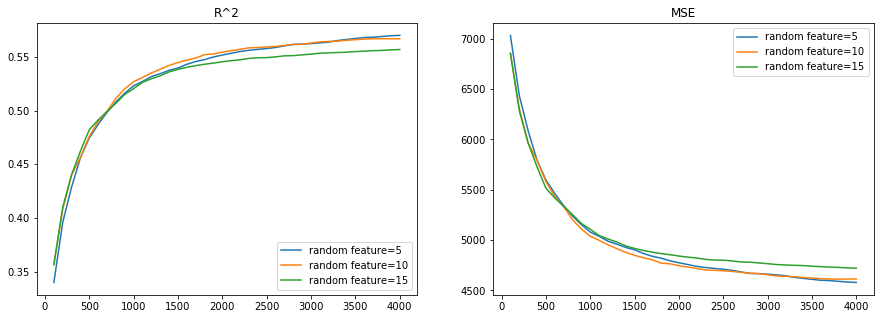

In [107]:
plt.figure()
f,plots=plt.subplots(1,2,figsize=(15,5))
p1,=plots[0].plot(N_ran,testscore[0])
p2,=plots[0].plot(N_ran,testscore[1])
p3,=plots[0].plot(N_ran,testscore[2])
plots[0].legend([p1,p2,p3],["random feature={}".format(feature_ran[0]),"random feature={}".format(feature_ran[1]),"random feature={}".format(feature_ran[2])])
plots[0].set_title('R^2')
p1,=plots[1].plot(N_ran,testmse[0])
p2,=plots[1].plot(N_ran,testmse[1])
p3,=plots[1].plot(N_ran,testmse[2])
plots[1].legend([p1,p2,p3],["random feature={}".format(feature_ran[0]),"random feature={}".format(feature_ran[1]),"random feature={}".format(feature_ran[2])])
plots[1].set_title('MSE')
plt.show()

# Random forest: more nodes lead to overfitting

In [109]:
N_ran=[i*100 for i in range(1,51)]
leaf_node_ran=[5,15,30]
testscore=[[0 for i in range(len(N_ran))] for j in range(len(leaf_node_ran))]
testmse=[[0 for i in range(len(N_ran))] for j in range(len(leaf_node_ran))]
for ln in range(len(leaf_node_ran)):
    gb=sklearn.ensemble.GradientBoostingRegressor(max_features=5,max_leaf_nodes=leaf_node_ran[ln],warm_start=True)
    for N in range(len(N_ran)):
        gb.set_params(n_estimators=N_ran[N])
        gb.fit(xtrain,ytrain)
        testscore[ln][N]=gb.score(xtest,ytest)
        testmse[ln][N]=gb.loss_(ytest,gb.predict(xtest))

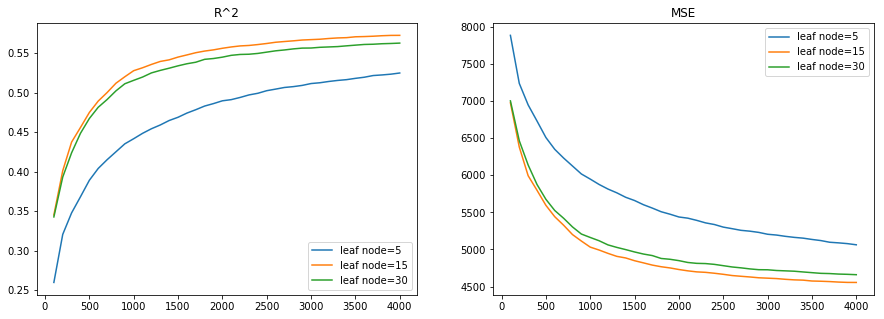

In [110]:
plt.figure()
f,plots=plt.subplots(1,2,figsize=(15,5))
p1,=plots[0].plot(N_ran,testscore[0])
p2,=plots[0].plot(N_ran,testscore[1])
p3,=plots[0].plot(N_ran,testscore[2])
legendcontent=["leaf node={}".format(leaf_node_ran[i]) for i in range(len(leaf_node_ran))]
plots[0].legend([p1,p2,p3],legendcontent)
plots[0].set_title('R^2')
p1,=plots[1].plot(N_ran,testmse[0])
p2,=plots[1].plot(N_ran,testmse[1])
p3,=plots[1].plot(N_ran,testmse[2])
plots[1].legend([p1,p2,p3],legendcontent)
plots[1].set_title('MSE')
plt.show()

In [119]:
N_ran=[i*20 for i in range(1,51)]
feature_ran=[5,15,20]
testscore=[[0 for i in range(len(N_ran))]for j in range(len(feature_ran))]
testmse=[[0 for i in range(len(N_ran))] for j in range(len(feature_ran))]
for f in range(len(feature_ran)):
    rf=sklearn.ensemble.RandomForestRegressor(warm_start=True,max_features=feature_ran[f],max_leaf_nodes=20)
    for N in range(len(N_ran)):
        rf.set_params(n_estimators=N_ran[N])
        rf.fit(xtrain,ytrain)
        testscore[f][N]=rf.score(xtest,ytest)
        yhat=rf.predict(xtest)
        testmse[f][N]=np.mean(np.power(yhat-ytest,2))

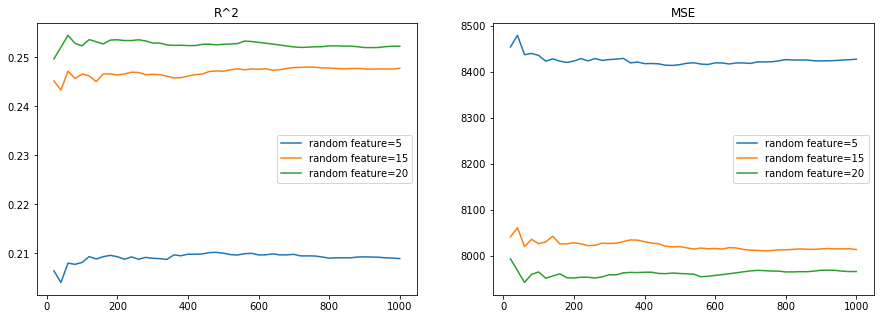

In [120]:
plt.figure()
f,plots=plt.subplots(1,2,figsize=(15,5))
p1,=plots[0].plot(N_ran,testscore[0])
p2,=plots[0].plot(N_ran,testscore[1])
p3,=plots[0].plot(N_ran,testscore[2])
plots[0].legend([p1,p2,p3],["random feature={}".format(feature_ran[0]),"random feature={}".format(feature_ran[1]),"random feature={}".format(feature_ran[2])])
plots[0].set_title('R^2')
p1,=plots[1].plot(N_ran,testmse[0])
p2,=plots[1].plot(N_ran,testmse[1])
p3,=plots[1].plot(N_ran,testmse[2])
plots[1].legend([p1,p2,p3],["random feature={}".format(feature_ran[0]),"random feature={}".format(feature_ran[1]),"random feature={}".format(feature_ran[2])])
plots[1].set_title('MSE')
plt.show()

# Random forest: the more nodes the better

In [117]:
N_ran=[i*10 for i in range(1,41)]
leaf_node_ran=[100,200,None]
testscore=[[0 for i in range(len(N_ran))] for j in range(len(leaf_node_ran))]
testmse=[[0 for i in range(len(N_ran))] for j in range(len(leaf_node_ran))]
for ln in range(len(leaf_node_ran)):
    rf=sklearn.ensemble.RandomForestRegressor(warm_start=True,max_features=20,max_leaf_nodes=leaf_node_ran[ln])
    for N in range(len(N_ran)):
        rf.set_params(n_estimators=N_ran[N])
        rf.fit(xtrain,ytrain)
        testscore[ln][N]=rf.score(xtest,ytest)
        yhat=rf.predict(xtest)
        testmse[ln][N]=np.mean(np.power(yhat-ytest,2))

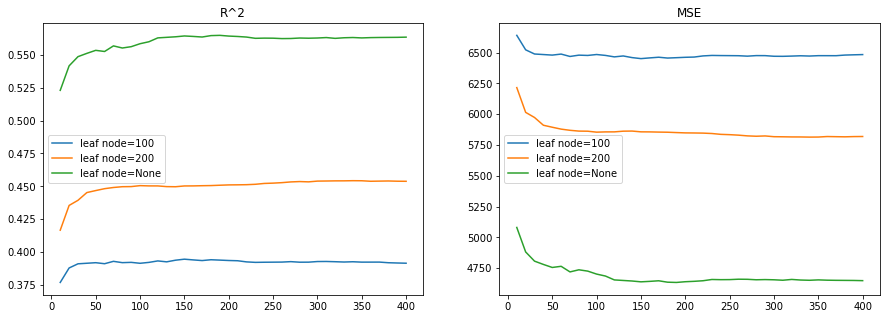

In [118]:
plt.figure()
f,plots=plt.subplots(1,2,figsize=(15,5))
p1,=plots[0].plot(N_ran,testscore[0])
p2,=plots[0].plot(N_ran,testscore[1])
p3,=plots[0].plot(N_ran,testscore[2])
plots[0].legend([p1,p2,p3],["leaf node={}".format(leaf_node_ran[0]),"leaf node={}".format(leaf_node_ran[1]),"leaf node={}".format(leaf_node_ran[2])])
plots[0].set_title('R^2')
p1,=plots[1].plot(N_ran,testmse[0])
p2,=plots[1].plot(N_ran,testmse[1])
p3,=plots[1].plot(N_ran,testmse[2])
plots[1].legend([p1,p2,p3],["leaf node={}".format(leaf_node_ran[0]),"leaf node={}".format(leaf_node_ran[1]),"leaf node={}".format(leaf_node_ran[2])])
plots[1].set_title('MSE')
plt.show()

In [131]:
N_ran_rf=[i*20 for i in range(1,51)]
testscore_rf=[0 for i in range(len(N_ran_rf))]
testmse_rf=[0 for i in range(len(N_ran_rf))]
N_ran_gb=[i*100 for i in range(1,41)]
testscore_gb=[0 for i in range(len(N_ran_gb))]
testmse_gb=[0 for i in range(len(N_ran_gb))]
rf=sklearn.ensemble.RandomForestRegressor(warm_start=True,max_features=20)
gb=sklearn.ensemble.GradientBoostingRegressor(warm_start=True,max_features=5,max_leaf_nodes=15)
for N in range(len(N_ran_rf)):
    rf.set_params(n_estimators=N_ran_rf[N])
    rf.fit(xtrain,ytrain)
    testscore_rf[N]=rf.score(xtest,ytest)
    yhat=rf.predict(xtest)
    testmse_rf[N]=np.mean(np.power(yhat-ytest,2))
for N in range(len(N_ran_gb)):
    gb.set_params(n_estimators=N_ran[N])
    gb.fit(xtrain,ytrain)
    testscore_gb[N]=gb.score(xtest,ytest)
    yhat=gb.predict(xtest)
    testmse_gb[N]=np.mean(np.power(yhat-ytest,2))

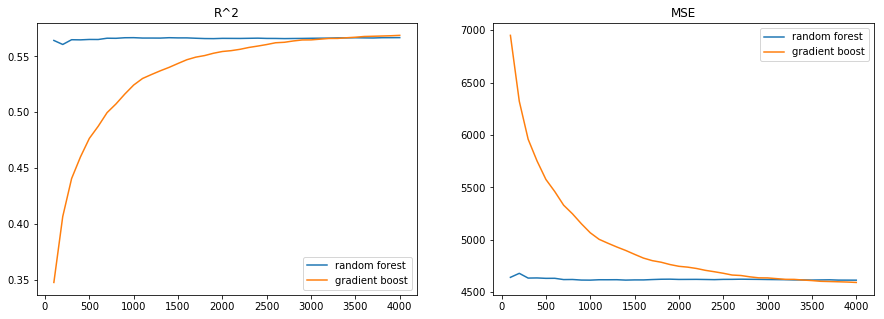

In [132]:
plt.figure()
f,plots=plt.subplots(1,2,figsize=(15,5))
p1,=plots[0].plot(N_ran,testscore_rf)
p2,=plots[0].plot(N_ran,testscore_gb)
plots[0].legend([p1,p2],["random forest","gradient boost"])
plots[0].set_title('R^2')
p1,=plots[1].plot(N_ran,testmse_rf)
p2,=plots[1].plot(N_ran,testmse_gb)
plots[1].legend([p1,p2],["random forest","gradient boost"])
plots[1].set_title('MSE')
plt.show()

In [123]:
gb=sklearn.ensemble.GradientBoostingRegressor(n_estimators=4000,max_features=5,max_leaf_nodes=15)
gb.fit(xtrain,ytrain)

array([ 0.01182817,  0.03243676,  0.04884795,  0.0367951 ,  0.04824696,
        0.0400186 ,  0.04589162,  0.03391841,  0.04772784,  0.02780033,
        0.04569983,  0.04537126,  0.04247582,  0.03017316,  0.05107716,
        0.0371465 ,  0.04656001,  0.02320266,  0.04574542,  0.03811723,
        0.04934317,  0.03456731,  0.02530919,  0.02338721,  0.0423486 ,
        0.03889223,  0.00707151])

In [125]:
gb.score(xtest,ytest)

0.57184706472441027

In [126]:
yhat=gb.predict(xtest)
np.mean(np.power(yhat-ytest,2))

4561.4032354799028

In [121]:
rf=sklearn.ensemble.RandomForestRegressor(n_estimators=400,max_features=20)
rf.fit(xtrain,ytrain)

array([ 0.03351201,  0.02596475,  0.03639194,  0.02930203,  0.03808673,
        0.05236863,  0.0450237 ,  0.03032297,  0.03270632,  0.02833127,
        0.04145705,  0.03012768,  0.03049936,  0.02650341,  0.03168815,
        0.04047942,  0.03153426,  0.02792365,  0.03050247,  0.0270426 ,
        0.04026089,  0.03152378,  0.02688126,  0.02028665,  0.03140172,
        0.1667728 ,  0.01310449])

In [122]:
rf.score(xtest,ytest)

0.56567030738093715

In [124]:
yhat=rf.predict(xtest)
np.mean(np.power(yhat-ytest,2))

4627.2084153816986

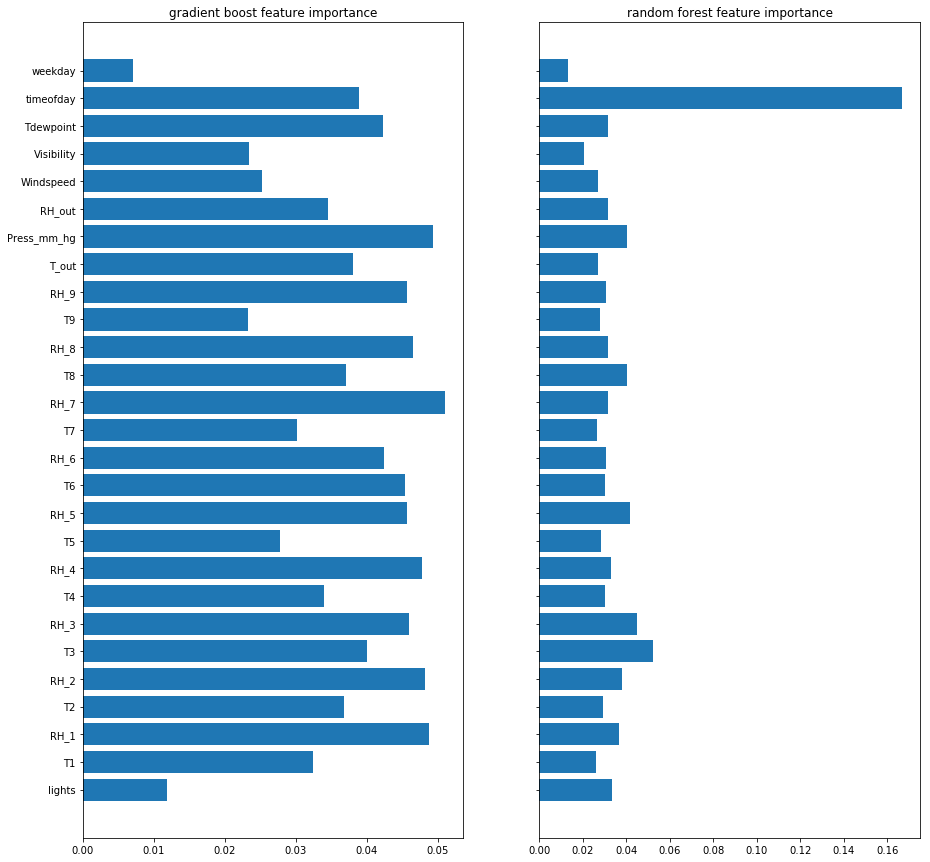

In [127]:
plt.figure()
f,plots=plt.subplots(1,2,figsize=(15,15),sharey=True)
plots[0].barh(np.arange(len(feature)),gb.feature_importances_)
plots[0].set_title('gradient boost feature importance')
plots[1].barh(np.arange(len(feature)),rf.feature_importances_)
plots[1].set_title('random forest feature importance')
plt.yticks(np.arange(len(feature)),feature)
plt.show()

In [128]:
yhat_gb=gb.predict(xtest)
res_gb=yhat_gb-ytest
yhat_rf=rf.predict(xtest)
res_rf=yhat_rf-ytest

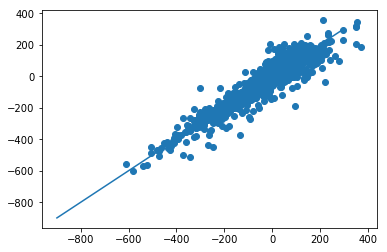

In [129]:
plt.figure()
plt.scatter(res_gb,res_rf)
plt.plot(range(-900,300),range(-900,300))
plt.show()

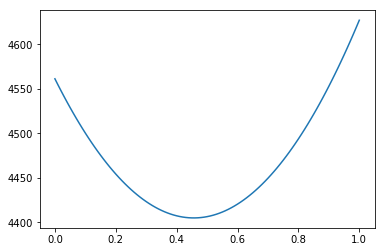

In [137]:
x_ran=[i*0.01 for i in range(101)]
combined_model=[np.mean(np.power(yhat_rf*x+yhat_gb*(1-x)-ytest,2)) for x in x_ran]
plt.figure()
plt.plot(x_ran,combined_model)
plt.show()